In [1]:
import math, re, os, warnings
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specify file paths
train_data_file_path = 'MRI Dataset/Data/train.parquet'
test_data_file_path = 'MRI Dataset/Data/test.parquet'

# Read data in
train_data = pd.read_parquet(train_data_file_path)
test_data = pd.read_parquet(test_data_file_path)

In [3]:
# Función para convertir bytes a imagen
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        return img
    return np.zeros((128, 128, 3))  # Return a blank image or handle it as needed

In [4]:
# Convertir las imágenes de bytes a arrays
train_data['image'] = train_data['image'].apply(dict_to_image)
test_data['image'] = test_data['image'].apply(dict_to_image)

In [5]:
# Dividir los datos en características (X) y etiquetas (y)
X = train_data['image']
y = train_data['label']

In [6]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=10)

In [7]:
# Dividir los datos de prueba
X_test = test_data['image']
y_test = test_data['label']

In [8]:
# Preprocesar los datos
from tensorflow.keras.utils import to_categorical

# Definir función de preprocesamiento
def preprocess_images(X):
    X_array = []
    for img in X:
        img = cv2.resize(img, (128, 128))  # Redimensionar las imágenes
        img = img / 255.0  # Normalizar las imágenes
        X_array.append(img)
    return np.array(X_array)

# Preprocesar los datos
X_train = preprocess_images(X_train)
X_val = preprocess_images(X_val)
X_test = preprocess_images(X_test)

# Convertir las etiquetas a formato categórico
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [9]:
# Definir el modelo
model = keras.Sequential([
    layers.Conv2D(kernel_size=3, filters=32, input_shape=(128, 128, 3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

In [10]:
# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Entrenar el modelo
start = time.time()
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=40,
                    batch_size=32)
print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5044 - loss: 1.0685 - val_accuracy: 0.5039 - val_loss: 1.0371
Epoch 2/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5417 - loss: 0.9777 - val_accuracy: 0.5766 - val_loss: 0.9299
Epoch 3/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5768 - loss: 0.9130 - val_accuracy: 0.6023 - val_loss: 0.8479
Epoch 4/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6381 - loss: 0.8017 - val_accuracy: 0.6523 - val_loss: 0.7827
Epoch 5/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6932 - loss: 0.7211 - val_accuracy: 0.6562 - val_loss: 0.7425
Epoch 6/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7624 - loss: 0.5879 - val_accuracy: 0.7617 - val_loss: 0.5935
Epoch 7/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7977 - loss: 0.4915 - val_accuracy: 0.7844 - val_loss: 0.5040
Epoch 8/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8653 - loss: 0.3616 - val_accu

In [12]:
# Guardar el modelo entrenado
model.save('alzheimer_model.h5')

In [13]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9538 - loss: 0.2188
Test accuracy: 0.957812488079071


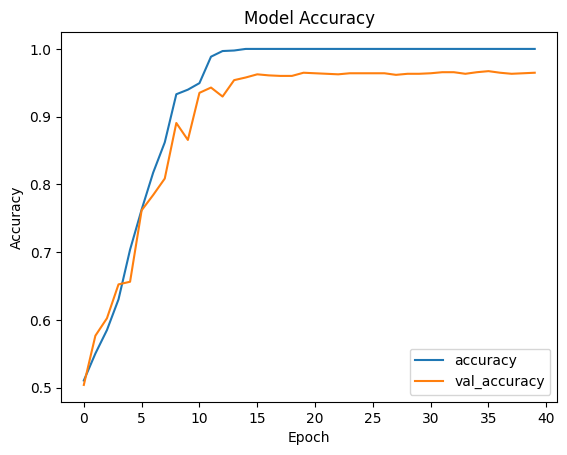

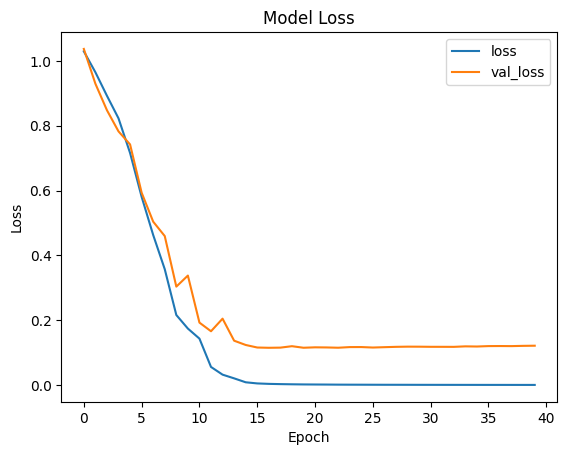

In [14]:
# Visualizar el historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

history_df[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()